In [2]:
! pip install -q kaggle
from google.colab import files

files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
100% 2.29G/2.29G [00:22<00:00, 91.7MB/s]
100% 2.29G/2.29G [00:22<00:00, 108MB/s] 


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [19]:
# Import necessary modules
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from glob import glob

In [41]:
# Provide image size, training, and testing data paths
IMAGESHAPE = [224, 224, 3]
training_data = '/content/chest_xray/train'
testing_data = '/content/chest_xray/test'

In [42]:
# Create VGG16 model with pre-trained weights from ImageNet
vgg_model = VGG16(input_shape=IMAGESHAPE, weights='imagenet', include_top=False)

# Set all layers in the VGG model as non-trainable
for each_layer in vgg_model.layers:
    each_layer.trainable = False


In [43]:
# Find how many classes (categories) are present in the training dataset
classes = glob('/content/chest_xray/train/*')
classes

['/content/chest_xray/train/NORMAL', '/content/chest_xray/train/PNEUMONIA']

In [44]:
# Flatten the VGG output and add a dense layer for prediction
flatten_layer = Flatten()(vgg_model.output)
prediction = Dense(len(classes), activation='softmax')(flatten_layer)

In [45]:
# Create the final model by combining VGG output and prediction
final_model = Model(inputs=vgg_model.input, outputs=prediction)
final_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [46]:
# Compile the model using categorical crossentropy loss and Adam optimizer
final_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [47]:
# Import ImageDataGenerator for data augmentation
from keras.preprocessing.image import ImageDataGenerator

# Create data generators for training and testing datasets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
testing_datagen = ImageDataGenerator(rescale=1./255)

In [48]:
# Generate batches of augmented data from the training and testing datasets
training_set = train_datagen.flow_from_directory(
    training_data,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

Found 5216 images belonging to 2 classes.


In [49]:
test_set = testing_datagen.flow_from_directory(
    testing_data,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

Found 624 images belonging to 2 classes.


In [50]:
# Train the model using fit_generator
fitted_model = final_model.fit(
    training_set,
    validation_data=test_set,
    epochs=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)


652/652 [==============================] - 3803s 6s/step - loss: 0.2073 - accuracy: 0.9304 - val_loss: 0.3410 - val_accuracy: 0.9071


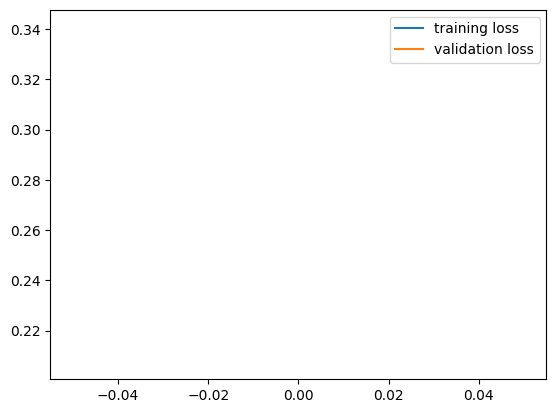

<Figure size 640x480 with 0 Axes>

In [51]:
# Plot and save the training and validation loss curves
plt.plot(fitted_model.history['loss'], label='training loss')
plt.plot(fitted_model.history['val_loss'], label='validation loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

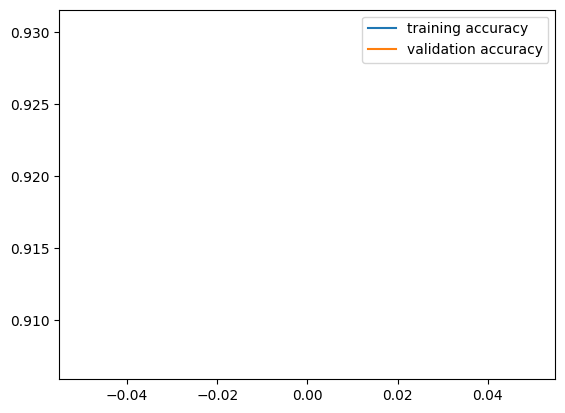

<Figure size 640x480 with 0 Axes>

In [52]:
# Plot and save the training and validation accuracy curves
plt.plot(fitted_model.history['accuracy'], label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [53]:
# Save the trained model
final_model.save('our_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
!pip install keras-preprocessing
# Load the trained model for testing
from keras_preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = load_model('our_model.h5')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 843.0 kB/s eta 0:00:00


In [56]:
# Load and preprocess a test image
img = image.load_img('/content/chest_xray/test/PNEUMONIA/person109_bacteria_519.jpeg', target_size=(224, 224))
image_data = image.img_to_array(img)
image_data = np.expand_dims(image_data, axis=0)
img_data = preprocess_input(image_data)


In [57]:
# Make predictions on the test image
prediction = model.predict(img_data)

# Print the prediction result
if prediction[0][0] > prediction[0][1]:
    print('Person is safe.')
else:
    print('Person is affected with Pneumonia.')
print(f'Predictions: {prediction}')

1/1 [==============================] - 2s 2s/step
Person is affected with Pneumonia.
Predictions: [[0. 1.]]
